# Data Exploration
This notebook continues the exploration started in part B (data processing) by conducting univariate, bivariate and multivariate analysis and answering the following questions:
1. What is the frequency of new reviews across time? 
2. Does the type of review (positive or negative), purchase place and type matter?
3. Do positive/negative reviews have more comments?
4. Do positive/negative reviews receive more votes_up or votes_funny?
5. Do positive/negative reviews have more playtime at the review time?
6. On average, do people that leave positive reviews play more after leaving the review? Calculate difference between review playtime and playtime at review extraction and create a standardized measure by dividing by the number of months.
7. Do people with more reviews leave positive reviews?
8. Do people that leave more reviews in general tend to receive the game for free?Or tend to leave more positive reviews?
9. Do people with more games in general tend to receive the game for free? Or tend to leave more positive reviews?
10. Optional: Create a feature that indicates the launch of a new patch and assess whether a new patch affects the frequency and type of reviews.

Readings:<br>
- https://medium.com/@yennhi95zz/outlier-detection-and-handling-with-python-techniques-and-examples-3094778ef4e
- https://towardsdatascience.com/a-data-scientists-essential-guide-to-exploratory-data-analysis-25637eee0cf6




In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data
gameid=892970
data= pd.read_csv("Data/"+str(gameid)+"_clean.csv")
data.head()

,recommendationid,review,recommended,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,steamid,...,num_reviews,timestamp_created_utc,timestamp_updated_utc,last_played_utc,playtime_forever_hour,playtime_last_two_weeks_hour,playtime_at_review_hour,timestamp_created_utc_ym,timestamp_updated_utc_ym,last_played_utc_ym
0,140348666,I played this for 99 minutes EXACTLY. and I HA...,False,0,0,0.00000,0,False,False,76561198090007828,...,78,2023-06-19 18:59:39,2023-06-19 18:59:39,2021-02-28 11:10:11,1.6,0.0,1.6,2023-06,2023-06,2021-02
1,140347990,"this game is amazing, and even better with the...",True,0,0,0.00000,0,True,False,76561199501472502,...,3,2023-06-19 18:46:33,2023-06-19 18:46:33,2023-06-19 19:24:03,29.8,29.8,29.2,2023-06,2023-06,2023-06
2,140347860,GAME IS horrible gave me fucking cancer sound,False,1,0,0.52381,1,True,False,76561199469648869,...,1,2023-06-19 18:43:53,2023-06-19 18:43:53,2023-06-19 18:42:45,19.4,3.0,19.4,2023-06,2023-06,2023-06
3,140345029,The only bad thing about this game is the amou...,True,0,0,0.00000,0,True,False,76561198082594466,...,4,2023-06-19 17:47:35,2023-06-19 17:47:35,2023-06-19 17:48:05,384.8,0.0,384.8,2023-06,2023-06,2023-06
4,140343169,nice,True,0,0,0.00000,0,True,False,76561198112578500,...,2,2023-06-19 17:09:31,2023-06-19 17:09:31,2023-06-19 19:13:12,49.7,2.0,47.6,2023-06,2023-06,2023-06


### Before exploring each question using manual EDA techniques, I will use the ProfileReport function from ydata_profiling library to output an automated EDA profile analysis using this dataset

In [9]:
def auto_profiling(data, title, file_out):
    from ydata_profiling import ProfileReport
    profile=ProfileReport(data, title=title)
    profile.to_file(file_out)
auto_profiling(data,title="Valheim's Steam Review EDA", file_out="Analysis/Valheim_auto_eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

> While exploring the ProfileReport output, I observe the following:
> - there four different **data types**: numeric, text, boolean and date;
> - existance of **skewed and imbalanced** features: recommended, votes_up, votes_funny, comment_count, received_for_free, num_reviews;
> - prevalence of **zeros**: votes_up, votes_funny, weighted_vote_score, comment_count, num_games_owned, playtime_last_two_weeks_hour.


> **Next**: an in-depth manually EDA will be conducted which aims to explore these high-level observations and to answer the 10 questions presented in first cell of the notebook.

---
### 1. What is the frequency of new reviews across time? 

To answer this question, I will start by plotting the total number of reviews across time (year-month as unit).

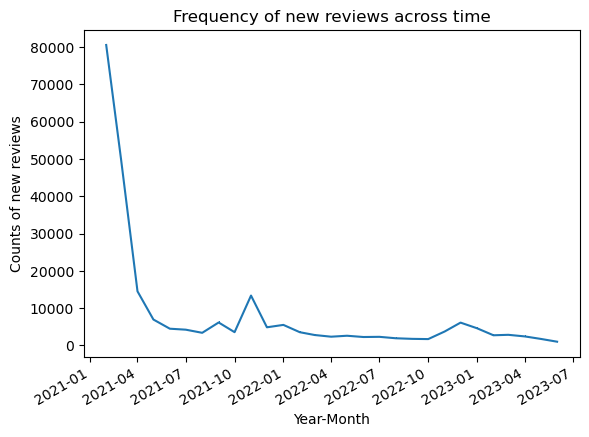

In [12]:
y=data['timestamp_created_utc_ym'].value_counts(sort=False)
y.index=pd.to_datetime(y.index)

fig, ax = plt.subplots()
ax.plot_date(y.index,y.values, fmt=",-")
ax.set(title = "Frequency of new reviews across time",
       xlabel = "Year-Month",
       ylabel = "Counts of new reviews")
fig.autofmt_xdate()
plt.show()

> **Observation**: There seems to be a high number of reviews in the first 3 months since the game was available for review. <br>
> **Next**: Let's look at total reviews created before and after April 2021

In [4]:
# total number of reviews created before or on April 2021 
y.loc[y.index <= '2021-04'].sum()

145017

In [5]:
y.tail(3)

2021-04-01    14509
2021-03-01    49923
2021-02-01    80585
Name: timestamp_created_utc_ym, dtype: int64

> **Observation**: In the first 3 months of availability, 145,017 new reviews were added by users (out of the 243,796) which constitutes ~60% of total reviews:
> - Feb 2021 - 80,585 reviews 
> - March 2021 - 49,923 reviews
> - April 2021 - 14,509 reviews

In [13]:
# After the first 3 months of availability, what are the months with the highest number of new reviews:
y.loc[y.index > '2021-04'].nlargest(5)

2021-11-01    13370
2021-05-01     6941
2021-09-01     6149
2022-12-01     6113
2022-01-01     5502
Name: timestamp_created_utc_ym, dtype: int64

---
### 2. Does the type of review (positive or negative), purchase place and type matter?
To answer this question, I will mainly use stacked histograms. 

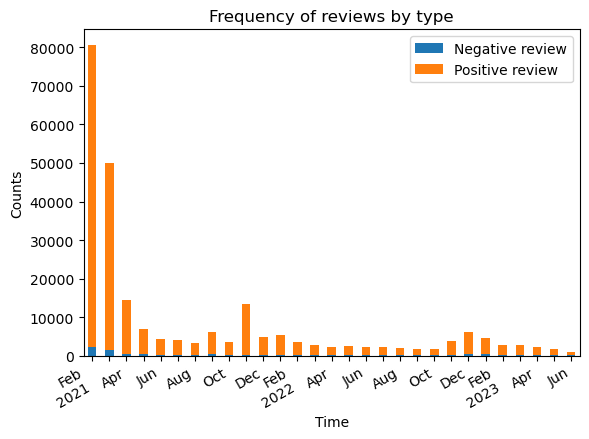

In [5]:
import matplotlib.ticker as ticker #I will use tickers to cluster months for readability

time_voted=data[['timestamp_created_utc_ym', 'recommended']].value_counts(sort=False).unstack()
ax = time_voted.plot(kind='bar',stacked=True)
time_voted.index=pd.to_datetime(time_voted.index)
ax.set_xlabel("Time") 
ax.set_ylabel("Counts") 
ax.set_title("Frequency of reviews by type")
ax.legend(["Negative review","Positive review"])
# Working with tickers on x axis
ticklabels = ['']*len(time_voted.index) # Making most of the ticklabels empty 
ticklabels[::2] = [item.strftime('%b') for item in time_voted.index[::2]] # Every 2th ticklable shows the month
ticklabels[::12] = [item.strftime('%b\n%Y') for item in time_voted.index[::12]] # Every 12th ticklabel includes the year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
plt.show()

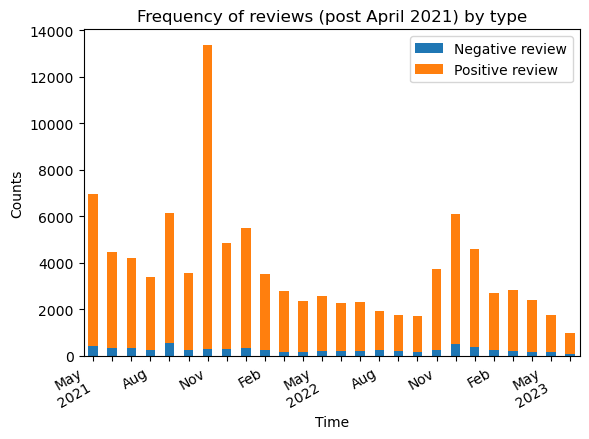

In [8]:
time_voted2=time_voted.loc[time_voted.index > '2021-04']
ax = time_voted2.plot.bar(stacked=True) 
ax.set_xlabel("Time") 
ax.set_ylabel("Counts") 
ax.legend(["Negative review","Positive review"])
ax.set_title("Frequency of reviews (post April 2021) by type")
ticklabels = ['']*len(time_voted2.index)
ticklabels[::3] = [item.strftime('%b') for item in time_voted2.index[::3]]
ticklabels[::12] = [item.strftime('%b\n%Y') for item in time_voted2.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
plt.show()

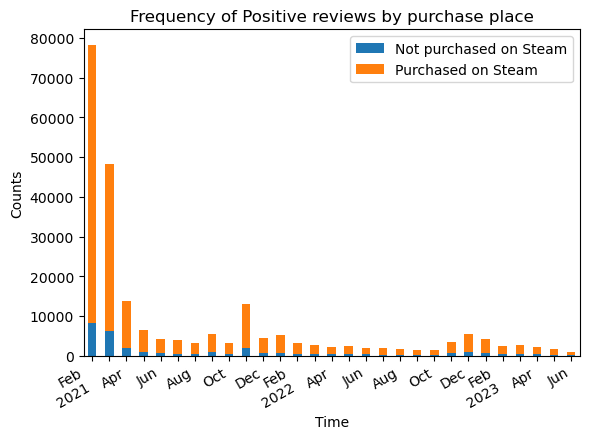

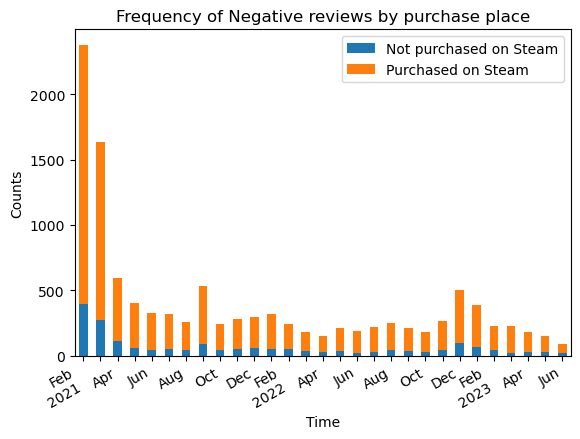

In [10]:
time_voted_dict={'Positive':[True, 'ax1'], 'Negative':[False, 'ax2']}
def plot_recommend_bivar(columns, var_desc, legend_desc):
    for key,value in time_voted_dict.items():
        df=data[columns].loc[data['recommended']==value[0]].value_counts(sort=False).unstack()
        df.index=pd.to_datetime(df.index)
        value[1] = df.plot.bar(stacked=True) 
        value[1].set_xlabel("Time") 
        value[1].set_ylabel("Counts") 
        value[1].set_title("Frequency of "+key+" reviews by "+var_desc)
        value[1].legend(legend_desc) 
        ticklabels = ['']*len(df.index)
        ticklabels[::2] = [item.strftime('%b') for item in df.index[::2]]
        ticklabels[::12] = [item.strftime('%b\n%Y') for item in df.index[::12]]
        value[1].xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
        plt.gcf().autofmt_xdate()
    plt.show()

plot_recommend_bivar(columns=['timestamp_created_utc_ym','steam_purchase'], var_desc='purchase place', 
                     legend_desc=["Not purchased on Steam","Purchased on Steam"])

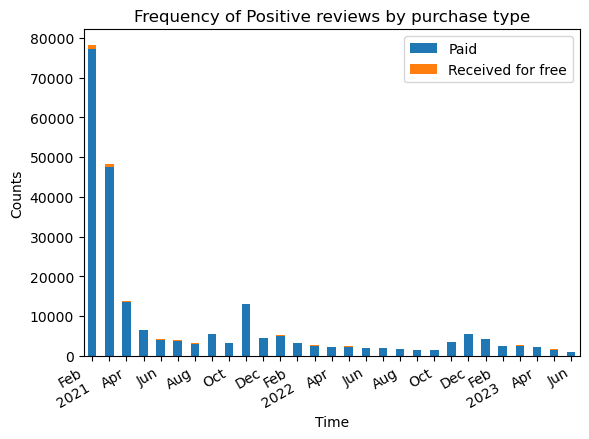

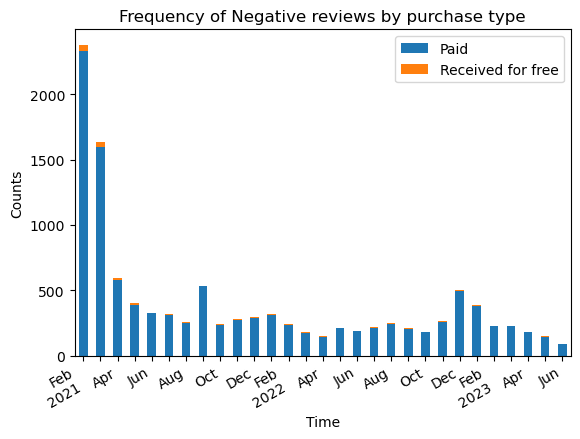

In [8]:
plot_recommend_bivar(['timestamp_created_utc_ym','received_for_free'], 'purchase type', 
                     ["Paid","Received for free"])

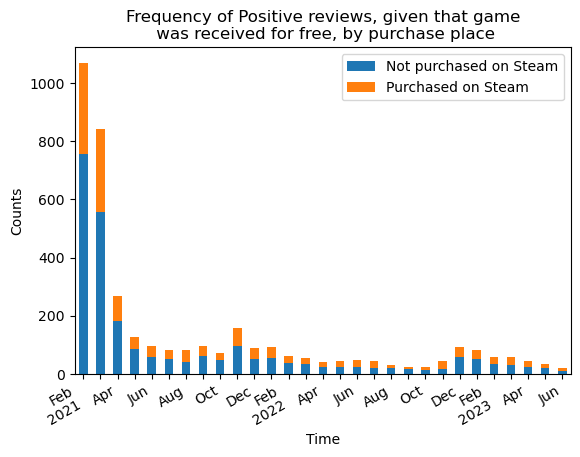

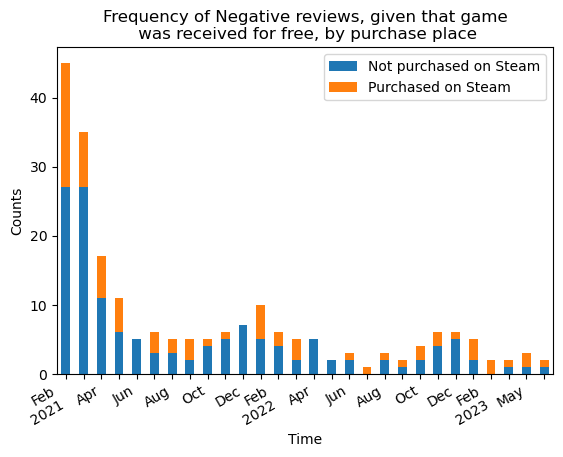

In [11]:
for key,value in time_voted_dict.items():
    df=data[['timestamp_created_utc_ym','steam_purchase']].loc[(data['recommended']==value[0])&(data['received_for_free']==True)
                                                              ].value_counts(sort=False).unstack()
    df.index=pd.to_datetime(df.index)
    value[1] = df.plot.bar(stacked=True) 
    value[1].set_xlabel("Time") 
    value[1].set_ylabel("Counts") 
    value[1].legend(["Not purchased on Steam","Purchased on Steam"])
    value[1].set_title("Frequency of "+key+" reviews, given that game\n was received for free, by purchase place")
    ticklabels = ['']*len(df.index)
    ticklabels[::2] = [item.strftime('%b') for item in df.index[::2]]
    ticklabels[::12] = [item.strftime('%b\n%Y') for item in df.index[::12]]
    value[1].xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
plt.show()

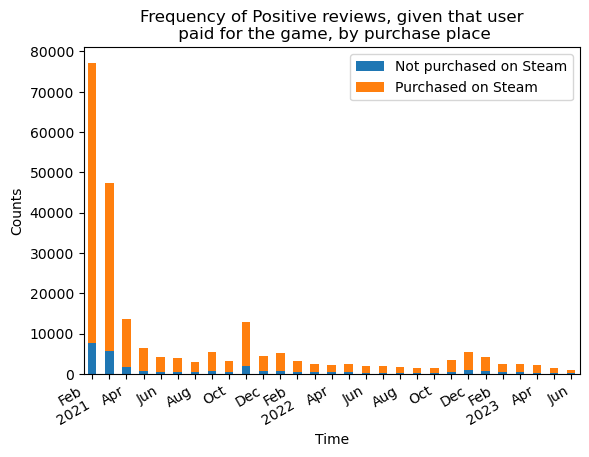

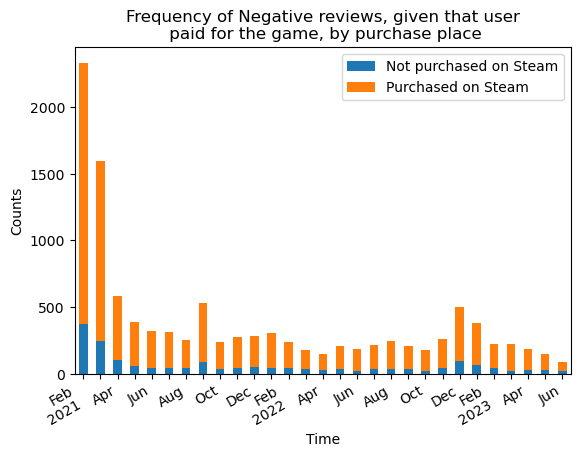

In [12]:
for key,value in time_voted_dict.items():
    df=data[['timestamp_created_utc_ym','steam_purchase']].loc[(data['recommended']==value[0])&(data['received_for_free']==False)
                                                              ].value_counts(sort=False).unstack()
    df.index=pd.to_datetime(df.index)
    value[1] = df.plot.bar(stacked=True) 
    value[1].set_xlabel("Time") 
    value[1].set_ylabel("Counts") 
    value[1].legend(["Not purchased on Steam","Purchased on Steam"])
    value[1].set_title("Frequency of "+key+" reviews, given that user\n paid for the game, by purchase place")
    ticklabels = ['']*len(df.index)
    ticklabels[::2] = [item.strftime('%b') for item in df.index[::2]]
    ticklabels[::12] = [item.strftime('%b\n%Y') for item in df.index[::12]]
    value[1].xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
plt.show()

> **Answer**:
- Purchase location: majority of reviews have purchased the products on Steam. The type of review (positive or negative) does not impact from where the game was purchased.
- Purchase type (free or paid): same situation as in the case of purchase location - majoritaty of reviews (both positive and negative) are created by users who paid for the game

---
### 3. Do positive/negative reviews have more comments?
To explore this question, I will use: 
- boxplot/violinplots as I am working with boolean features;
- outliers identification methods as I am explorting skewed distributions with potential long tails;
- ratio calculations as I am looking at imbalanced features.

In [4]:
#Total number of comments
data['comment_count'].sum()

9852

<Axes: xlabel='recommended', ylabel='comment_count'>

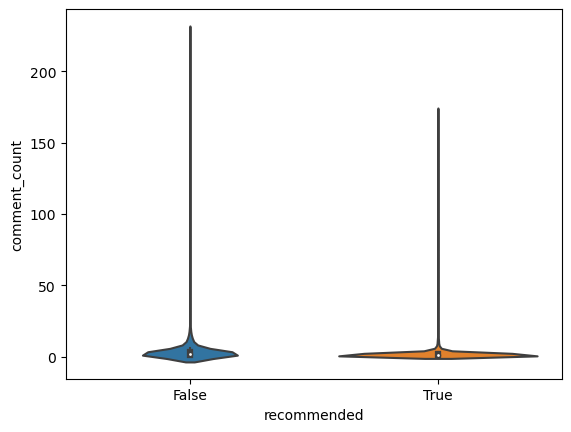

In [17]:
## Boxplots to visualize the distribution of comments by review type
#df=data[['voted_up','comment_count']]
df=data[['recommended','comment_count']].loc[data['comment_count']>0] #filtering out reviews without any comments
sns.violinplot(df,x="recommended", y="comment_count")

> Visually, the violin plots indicate the existance of several outlier observations → I will use different approches to identify outliers while keeping in mind that the distribution is right-skewed

#### Outlier identification methods

##### A. Z scores

<Axes: xlabel='recommended', ylabel='comment_count'>

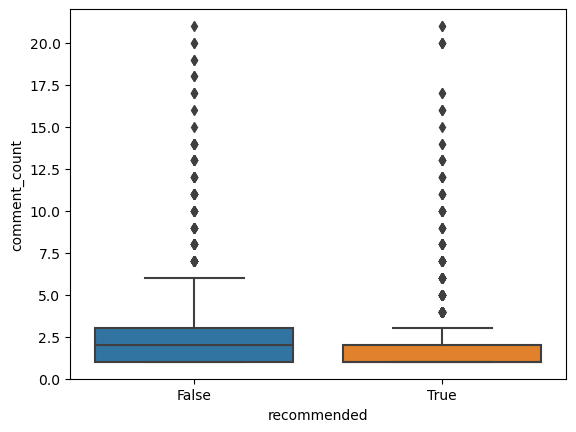

In [21]:
def z_scores_detection_outliers(dataset, column_name, threshold=3):
    z_scores = (dataset[column_name] - dataset[column_name].mean()) /dataset[column_name].std()
    return dataset[~(z_scores > threshold)]
df_no_outliers=z_scores_detection_outliers(df, "comment_count")
sns.boxplot(df_no_outliers,x="recommended", y="comment_count")

In [26]:
print("Feature shape before outliers removal using Z scores: {}".format(df["comment_count"].shape))
print("Feature shape after outliers removal using Z scores: {}".format(df_no_outliers["comment_count"].shape))

Feature shape before outliers removal using Z scores: (4197,)
Feature shape after outliers removal using Z scores: (4162,)


##### B. IQR (Interquartile Range)

In [20]:
#def iqr_detection_outliers(dataset, column_name, range_list=[25, 75]):
q1, q3 = np.percentile(df['comment_count'], [25, 75])
iqr = q3 - q1
threshold = 1.5
sum(df['comment_count'] > q3 - threshold * iqr)
#outlier_indices = np.where((target < q1 - threshold * iqr) | (target > q3 + threshold * iqr))[0]

4197

##### C. Winsorization

In [22]:
from scipy.stats import mstats
winsorized_target = mstats.winsorize(df['comment_count'] , limits=[0.05, 0.05])
winsorized_target.shape

(4197,)

Ratio comment/review

In [15]:
x=pd.pivot_table(data[['recommended','comment_count']], values='comment_count',index='recommended', aggfunc=np.sum)
x

,comment_count
recommended,
False,3319
True,6533


In [16]:
y=pd.pivot_table(data[['recommended','comment_count']], values='comment_count',index='recommended', aggfunc='count')
y

,comment_count
recommended,
False,11457
True,232339


In [17]:
x/y

,comment_count
recommended,
False,0.289692
True,0.028118


> In terms of frequency of comments per review type, 

In [18]:
df.sort_values('comment_count', ascending=False).head(10)

,recommended,comment_count
231453,False,227
218007,True,172
120533,True,136
180768,True,100
81118,True,87
236030,False,82
197089,True,73
233661,True,61
161019,False,54
238499,True,52


In [23]:
#Total number of comment by review type
x=pd.pivot_table(data[['recommended','comment_count']], values='comment_count', index='recommended', aggfunc=np.sum)
x

,comment_count
recommended,
False,3319
True,6533


In [14]:
#Total number of positive & negative reviews
y=pd.pivot_table(data[['recommended','comment_count']], values='comment_count', index='recommended', aggfunc='count')
y

,comment_count
recommended,
False,11457
True,232339


In [25]:
#Ratio of comments by review type
x/y

,comment_count
recommended,
False,0.289692
True,0.028118


In [27]:
#out of the total positive or negative reviews, how many have at least 1 comment
df=data[['recommended','comment_count']].loc[data['comment_count']>0]
pd.pivot_table(df, values='comment_count',index='recommended', aggfunc='count')/y*100

,comment_count
recommended,
False,7.995112
True,1.412161


> **Answer**:
<ul>
 - ~8% of negative reviews have at least one comment while only 1.4% of positive reviews have at least 1 comment<br>
 - Ratio comment/review: 0.28 comments to a negative review and 0.02 comments to a positive review
</ul>

> → There is a higher interaction with negative reviews than with positive reviews

### 4. Do positive/negative reviews receive more votes_up or votes_funny?

In [28]:
#Total number of votes_up
data['votes_up'].sum()

230545

<Axes: xlabel='recommended', ylabel='votes_up'>

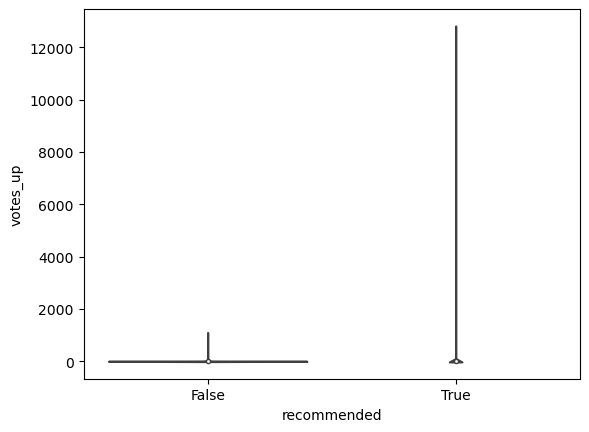

In [29]:
df=data[['recommended','votes_up']].loc[data['votes_up']>0]
sns.violinplot(df,x="recommended", y="votes_up")

In [30]:
df.sort_values('votes_up', ascending=False).head(10)

,recommended,votes_up
218007,True,12801
180768,True,7545
197089,True,4799
120533,True,4551
241592,True,3885
237831,True,3665
241184,True,2555
161449,True,2294
239537,True,2215
238499,True,2169


In [31]:
#Total number of positive and negative reviews
y=pd.pivot_table(data[['recommended','votes_up']], values=['recommended','votes_up'], index='recommended', aggfunc='count')
y

,votes_up
recommended,
False,11457
True,232339


In [32]:
#Total number of votes_up by review type
x=pd.pivot_table(data[['recommended','votes_up']], values='votes_up',index='recommended', aggfunc=np.sum)
x

,votes_up
recommended,
False,38538
True,192007


In [33]:
#Ratio of votes_up by review type
x/y

,votes_up
recommended,
False,3.363708
True,0.826409


>**Positive reviews**
<ul>
    - Total : 232,339<br>
    - Votes up: 192,007<br>
    - Ratio: 0.82 of votes up to a positive review
</ul>

>**Negative reviews**
<ul>
    - Total : 11,457<br>
    - Votes up: 38,538<br>
    - Ratio: 3.36 of votes up to a negative review
</ul>

In [34]:
#out of the total positive or negative reviews, how many have at least 1 vote up (helpful)
df=data[['recommended','votes_up']].loc[data['votes_up']>0]
pd.pivot_table(df, values='votes_up',index='recommended', aggfunc='count')/y*100

,votes_up
recommended,
False,64.824998
True,19.736247


> **Observation:** ~65% of negative reviews have at least one vote up while only ~20% of positive reviews have one vote up

In [35]:
#Total number of votes_funny
data['votes_funny'].sum()

48258

<Axes: xlabel='recommended', ylabel='votes_funny'>

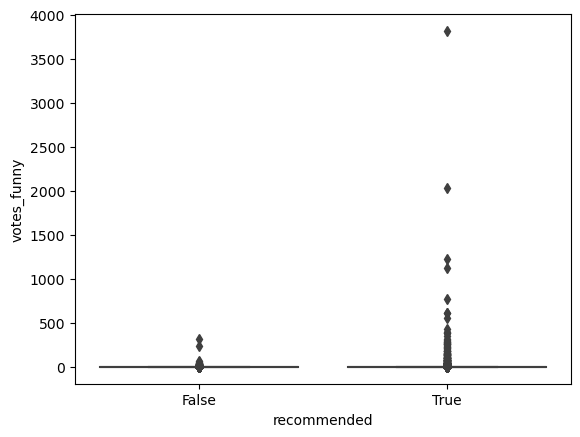

In [36]:
df=data[['recommended','votes_funny']].loc[data['votes_funny']>0]
sns.boxplot(df,x="recommended", y="votes_funny")

In [37]:
df.sort_values('votes_funny', ascending=False).head(10)

,recommended,votes_funny
237831,True,3819
163531,True,2034
81118,True,1225
103323,True,1124
235750,True,777
14243,True,618
195479,True,616
180768,True,552
237529,True,432
101626,True,393


In [39]:
#Total number of positive and negative reviews
y=pd.pivot_table(data[['recommended','votes_funny']], values=['recommended','votes_funny'], index='recommended', aggfunc='count')
y

,votes_funny
recommended,
False,11457
True,232339


In [40]:
#Total number of votes_funny by review type
x=pd.pivot_table(data[['recommended','votes_funny']], values='votes_funny',index='recommended', aggfunc=np.sum)
x

,votes_funny
recommended,
False,9086
True,39172


In [41]:
#Ratio of vote funny by review type
x/y

,votes_funny
recommended,
False,0.793052
True,0.168598


In [42]:
#out of the total positive or negative reviews, how many have at least 1 funny vote 
df=data[['recommended','votes_funny']].loc[data['votes_funny']>0]
pd.pivot_table(df, values='votes_funny',index='recommended', aggfunc='count')/y

,votes_funny
recommended,
False,0.337261
True,0.045253


> ~34% of the negative reviews have at least 1 funny vote while only 4% of the positive reviews have at least 1 funny vote

> **Answer**:
When looking at votes_up (helpfulness) and votes_funny, Steam users interact more with negative than with positive reviews:<br>
<br>
    Out of the 11.457 total negative reviews, which constitutes 5% of total reviews:<br>
    <ul>
        * ~65% have at least 1 vote up<br>
        * ~34% have at least 1 funny vote<br>
    </ul>
    <br>
    Out of the 232.339 total positive reviews, which constitutes 95% of total reviews:<br>
    <ul>
        * ~20% have at least 1 vote up<br>
        * ~4% have at least 1 funny vote<br>
    </ul>

### 5. Do positive/negative reviews have more playtime at the review time?

<Axes: xlabel='recommended', ylabel='playtime_at_review_hour'>

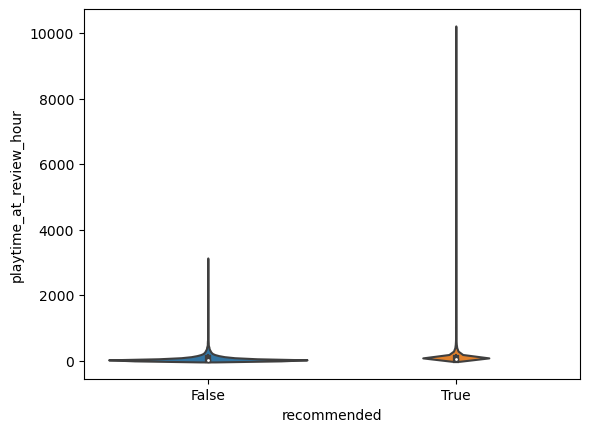

In [45]:
df=data[['recommended','playtime_forever_hour','playtime_at_review_hour']]
sns.violinplot(df,x="recommended", y="playtime_at_review_hour")

In [55]:
#Total number of hours spent playing in total and at review time by review type
x=pd.pivot_table(data[['recommended','playtime_forever_hour','playtime_at_review_hour']], 
                 values=['playtime_forever_hour','playtime_at_review_hour'], index='recommended', aggfunc=np.sum)
#x
#Total number of positive & negative reviews
y=pd.pivot_table(data[['recommended','playtime_forever_hour','playtime_at_review_hour']], values=['playtime_forever_hour','playtime_at_review_hour'], index='recommended', aggfunc='count')
#y
#Ratio of hours spent playing in total and at review time by review type
x/y

,playtime_at_review_hour,playtime_forever_hour
recommended,,
False,65.317989,111.389500
True,69.421606,192.183449


> On average, reviewers who recommend the game tend to spent more time playing the game than those who don't recommend the game.
A reviewer who **doesn't recommend** the game spends, on average, **65 mins before leaving a review**

In [ ]:
#negative reviews under 2 h at review time are not gonna have more than 2 h total playtime on average, 
#due to Steam policy of reimbursement


### 6. On averge, do people that leave positive reviews play more after leaving the review? 
Calculate difference between review playtime and playtime at review extraction and create a standardized measure by dividing by the number of months.

### 7. Do people with more reviews leave positive reviews?

### 8. Do people that leave more reviews in general tend to receive the game for free?Or tend to leave more positive reviews?

### 9. Do people with more games in general tend to receive the game for free? Or tend to leave more positive reviews?

### 10. Create a feature that indicates the launch of a new patch and assess whether a new patch affects the frequency and type of reviews.

---
### Conclusions
This EDA has focused on answering 10 main questions regarding the Valheim Steam Reviews dataset in order to provide a better understanding of the different features, patterns present in the datset while also identifying potential issues that might impact the next steps.

First, the automated ProfilingReport indicated the prevelance of skewed and imbalanced features

By looking at the reviews' frequency, we noticed that the game had a big reception when it first launched as an early access game as 145,017 or ~60% of total reviews were posted in first 3 months of game's availability.

Majority of reviews have purchased the game on Steam. The type of review (positive or negative) does not impact from where the game was purchased.